https://thebook.io/080324/part05/ch19/

### 19장 세상에 없는 얼굴 GAN, 오토인코더

진짜 같은 가짜를 만들기 위해 GAN 알고리즘 내부에서는 ‘적대적’ 경합을 진행하기 때문  
Generator(생성자) vs Discriminator(판별자: 데이터 진위여부 판별) 갈수록 가짜가 정교해짐

실습: GAN 모델 만들기

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
generator = models.Sequential()
generator.add(layers.Dense(7*7*128, input_dim=100, activation=layers.LeakyReLU(0.2)))
# output 7*7*128, input 100
# activation=layers.LeakyReLU(0.2) 하이퍼 파라미터
generator.add(layers.BatchNormalization())
# BatchNormalization() 0~1 사이로 스케일링
generator.add(layers.Reshape((7, 7, 128)))
# Reshape(7, 7, 128) 7x7의 이미지를 128개의 채널로
generator.add(layers.UpSampling2D())
# UpSampling2D() 맥스풀링과 반대개념 output shape 14x14
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
# kernel_size=5  5x5 커널 사용
# padding='same' 원본사이즈 유지->커널을 사용하여 줄어들 픽셀수만큼 확장하고 
#                              확장한 픽셀에 0값을 지정한 뒤에 커널 적용
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

batch_normalization 파라미터 계산은 Non-trainable params도 포함되어있고.. 여튼 복잡

In [3]:
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, input_shape=(28, 28, 1), strides=2,
                                padding='same'))
# strides=2 한개씩 건너뛰면서 특성 생성.. 
# 픽셀값이 비슷한 영역이 많은 단순한 그림같은 경우에는 strides=2의 결과에 영향 별로 없음 속도는 빨라짐
# 픽셀 구조가 복잡한 그림은 strides=2 결과에 영향이 크다
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# metrics 사용x 이 모델은 생성자가 만든 것과 진짜를 비교해 오차값을 출력해주는 것
discriminator.trainable = False
# 기본 옵션의 파라미터의 학습을 막아둔다
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

Non-trainable params: 212,865 학습을 막아두었기때문

In [4]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [5]:
if not os.path.exists('data/gan_images'):
    os.mkdir('data/gan_images')
    
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train = (X_train - 127.5) / 127.5
    # (X_train - 127.5) / 127.5 출력값은 -1 ~ 1
    # X_train 판별자가 판별을 제대로 하기 위한 학습 데이터와 비교해서 오차값을 알려줌
    # generator 최종출력 activation='tanh'에 맞추기 위한것
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        
        # 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        # X_train.shape[0] X_train데이터 전체갯수 
        # randint 0부터 X_train.shape[0] 사이의 값을 랜덤하게 뽑아 인덱싱
        imgs = X_train[idx] #임의로 랜덤하게 뽑은
        d_loss_real = discriminator.train_on_batch(imgs, true)
        # d_loss_real 의미 : discriminator이 진짜그림을 판별해서 만들어낸 오차
        # 전부 true로 설정해서 discriminator.trainable = False에서 막아뒀던 학습을 한다  
        
        # 가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))
        # random.normal 정규분포
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # 판별자가 가짜 이미지를 학습하며 만든 오차
        # 이 이미지들은 가짜라고 학습시킴
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        # 전부 진짜라고우겼을때 생성자의 오차
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 166ms/step
epoch:0  d_loss:0.6997  g_loss:0.7608
1/1 [==============================] - 0s 29ms/step
epoch:1  d_loss:0.4548  g_loss:0.4727
1/1 [==============================] - 0s 29ms/step
epoch:2  d_loss:0.4275  g_loss:0.1072
1/1 [==============================] - 0s 30ms/step
epoch:3  d_loss:0.5931  g_loss:0.0230
1/1 [==============================] - 0s 30ms/step
epoch:4  d_loss:0.7140  g_loss:0.0267
1/1 [==============================] - 0s 31ms/step
epoch:5  d_loss:0.6377  g_loss:0.1146
1/1 [==============================] - 0s 30ms/step
epoch:6  d_loss:0.5138  g_loss:0.3910
1/1 [==============================] - 0s 37ms/step
epoch:7  d_loss:0.4991  g_loss:0.7028
1/1 [==============================] - 0s 36ms/step
epoch:8  d_loss:0.5137  g_loss:0.8320
1/1 [==============================] - 0s 30ms/step
epoch:9  d_loss:0.4952  g_loss:0.8218
1/1 [==============================] - 0s 30ms/step
epoch:10  d_loss:0.4376  g_loss:0.8392
1/1 [===

epoch:89  d_loss:0.3084  g_loss:2.5437
1/1 [==============================] - 0s 30ms/step
epoch:90  d_loss:0.3468  g_loss:3.3848
1/1 [==============================] - 0s 29ms/step
epoch:91  d_loss:0.4414  g_loss:3.6248
1/1 [==============================] - 0s 32ms/step
epoch:92  d_loss:0.7092  g_loss:3.1425
1/1 [==============================] - 0s 32ms/step
epoch:93  d_loss:0.7556  g_loss:2.5868
1/1 [==============================] - 0s 32ms/step
epoch:94  d_loss:0.7592  g_loss:2.0418
1/1 [==============================] - 0s 31ms/step
epoch:95  d_loss:0.6125  g_loss:2.3706
1/1 [==============================] - 0s 31ms/step
epoch:96  d_loss:0.8092  g_loss:2.4210
1/1 [==============================] - 0s 35ms/step
epoch:97  d_loss:0.5821  g_loss:2.1405
1/1 [==============================] - 0s 47ms/step
epoch:98  d_loss:0.7903  g_loss:1.8107
1/1 [==============================] - 0s 31ms/step
epoch:99  d_loss:0.7311  g_loss:1.4206
1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 32ms/step
epoch:179  d_loss:0.5546  g_loss:1.3264
1/1 [==============================] - 0s 41ms/step
epoch:180  d_loss:0.4113  g_loss:1.7811
1/1 [==============================] - 0s 32ms/step
epoch:181  d_loss:0.6749  g_loss:1.5544
1/1 [==============================] - 0s 32ms/step
epoch:182  d_loss:0.5639  g_loss:1.4547
1/1 [==============================] - 0s 41ms/step
epoch:183  d_loss:0.5702  g_loss:1.2225
1/1 [==============================] - 0s 29ms/step
epoch:184  d_loss:0.5578  g_loss:1.2546
1/1 [==============================] - 0s 30ms/step
epoch:185  d_loss:0.5885  g_loss:1.2902
1/1 [==============================] - 0s 30ms/step
epoch:186  d_loss:0.6958  g_loss:1.0077
1/1 [==============================] - 0s 32ms/step
epoch:187  d_loss:0.7089  g_loss:1.0142
1/1 [==============================] - 0s 30ms/step
epoch:188  d_loss:0.6448  g_loss:1.2974
1/1 [==============================] - 0s 32ms/step
epoch:189  d_loss:0.6304  g_

1/1 [==============================] - 0s 32ms/step
epoch:356  d_loss:0.2811  g_loss:2.6420
1/1 [==============================] - 0s 30ms/step
epoch:357  d_loss:0.3694  g_loss:2.3506
1/1 [==============================] - 0s 30ms/step
epoch:358  d_loss:0.2836  g_loss:2.7005
1/1 [==============================] - 0s 30ms/step
epoch:359  d_loss:0.3372  g_loss:3.0946
1/1 [==============================] - 0s 36ms/step
epoch:360  d_loss:0.1263  g_loss:3.9375
1/1 [==============================] - 0s 33ms/step
epoch:361  d_loss:0.3648  g_loss:3.7980
1/1 [==============================] - 0s 29ms/step
epoch:362  d_loss:0.3348  g_loss:3.3413
1/1 [==============================] - 0s 32ms/step
epoch:363  d_loss:0.4125  g_loss:2.7628
1/1 [==============================] - 0s 30ms/step
epoch:364  d_loss:0.4131  g_loss:2.6560
1/1 [==============================] - 0s 30ms/step
epoch:365  d_loss:0.3963  g_loss:3.3977
1/1 [==============================] - 0s 31ms/step
epoch:366  d_loss:0.4024  g_

1/1 [==============================] - 0s 29ms/step
epoch:533  d_loss:0.2819  g_loss:2.6862
1/1 [==============================] - 0s 31ms/step
epoch:534  d_loss:0.3873  g_loss:2.0190
1/1 [==============================] - 0s 31ms/step
epoch:535  d_loss:0.3369  g_loss:1.9241
1/1 [==============================] - 0s 30ms/step
epoch:536  d_loss:0.3303  g_loss:2.0962
1/1 [==============================] - 0s 33ms/step
epoch:537  d_loss:0.2895  g_loss:2.1935
1/1 [==============================] - 0s 33ms/step
epoch:538  d_loss:0.3106  g_loss:2.3357
1/1 [==============================] - 0s 30ms/step
epoch:539  d_loss:0.4458  g_loss:2.0513
1/1 [==============================] - 0s 29ms/step
epoch:540  d_loss:0.2463  g_loss:2.0132
1/1 [==============================] - 0s 30ms/step
epoch:541  d_loss:0.2110  g_loss:2.1197
1/1 [==============================] - 0s 31ms/step
epoch:542  d_loss:0.3628  g_loss:2.1077
1/1 [==============================] - 0s 33ms/step
epoch:543  d_loss:0.2183  g_

1/1 [==============================] - 0s 32ms/step
epoch:710  d_loss:0.7160  g_loss:2.9255
1/1 [==============================] - 0s 31ms/step
epoch:711  d_loss:0.7049  g_loss:3.1914
1/1 [==============================] - 0s 30ms/step
epoch:712  d_loss:0.4809  g_loss:3.4300
1/1 [==============================] - 0s 32ms/step
epoch:713  d_loss:0.6507  g_loss:2.9453
1/1 [==============================] - 0s 29ms/step
epoch:714  d_loss:0.3851  g_loss:3.5845
1/1 [==============================] - 0s 32ms/step
epoch:715  d_loss:0.4865  g_loss:2.8833
1/1 [==============================] - 0s 31ms/step
epoch:716  d_loss:0.5454  g_loss:2.4643
1/1 [==============================] - 0s 33ms/step
epoch:717  d_loss:0.3128  g_loss:2.1052
1/1 [==============================] - 0s 30ms/step
epoch:718  d_loss:0.2829  g_loss:2.0791
1/1 [==============================] - 0s 31ms/step
epoch:719  d_loss:0.3993  g_loss:1.9417
1/1 [==============================] - 0s 39ms/step
epoch:720  d_loss:0.3351  g_

1/1 [==============================] - 0s 33ms/step
epoch:887  d_loss:0.3985  g_loss:2.1932
1/1 [==============================] - 0s 32ms/step
epoch:888  d_loss:0.3782  g_loss:2.0234
1/1 [==============================] - 0s 31ms/step
epoch:889  d_loss:0.4497  g_loss:1.9676
1/1 [==============================] - 0s 31ms/step
epoch:890  d_loss:0.3755  g_loss:2.3753
1/1 [==============================] - 0s 40ms/step
epoch:891  d_loss:0.3272  g_loss:2.3580
1/1 [==============================] - 0s 35ms/step
epoch:892  d_loss:0.2740  g_loss:2.8612
1/1 [==============================] - 0s 30ms/step
epoch:893  d_loss:0.3256  g_loss:2.6483
1/1 [==============================] - 0s 30ms/step
epoch:894  d_loss:0.3118  g_loss:2.2441
1/1 [==============================] - 0s 32ms/step
epoch:895  d_loss:0.3379  g_loss:2.4070
1/1 [==============================] - 0s 31ms/step
epoch:896  d_loss:0.2210  g_loss:2.1498
1/1 [==============================] - 0s 36ms/step
epoch:897  d_loss:0.1739  g_

1/1 [==============================] - 0s 32ms/step
epoch:1064  d_loss:0.2875  g_loss:2.2969
1/1 [==============================] - 0s 31ms/step
epoch:1065  d_loss:0.2268  g_loss:2.4186
1/1 [==============================] - 0s 30ms/step
epoch:1066  d_loss:0.3200  g_loss:2.4279
1/1 [==============================] - 0s 31ms/step
epoch:1067  d_loss:0.2802  g_loss:2.0568
1/1 [==============================] - 0s 30ms/step
epoch:1068  d_loss:0.2945  g_loss:2.4843
1/1 [==============================] - 0s 31ms/step
epoch:1069  d_loss:0.2551  g_loss:2.5284
1/1 [==============================] - 0s 30ms/step
epoch:1070  d_loss:0.2915  g_loss:2.2719
1/1 [==============================] - 0s 31ms/step
epoch:1071  d_loss:0.3204  g_loss:2.3624
1/1 [==============================] - 0s 36ms/step
epoch:1072  d_loss:0.3019  g_loss:2.0900
1/1 [==============================] - 0s 30ms/step
epoch:1073  d_loss:0.2327  g_loss:2.5913
1/1 [==============================] - 0s 30ms/step
epoch:1074  d_loss

epoch:1239  d_loss:0.3931  g_loss:1.7937
1/1 [==============================] - 0s 30ms/step
epoch:1240  d_loss:0.3775  g_loss:2.2137
1/1 [==============================] - 0s 32ms/step
epoch:1241  d_loss:0.4001  g_loss:2.6199
1/1 [==============================] - 0s 30ms/step
epoch:1242  d_loss:0.3562  g_loss:2.7534
1/1 [==============================] - 0s 33ms/step
epoch:1243  d_loss:0.4047  g_loss:1.9714
1/1 [==============================] - 0s 29ms/step
epoch:1244  d_loss:0.3580  g_loss:1.8384
1/1 [==============================] - 0s 31ms/step
epoch:1245  d_loss:0.3734  g_loss:2.1310
1/1 [==============================] - 0s 30ms/step
epoch:1246  d_loss:0.3914  g_loss:2.3755
1/1 [==============================] - 0s 30ms/step
epoch:1247  d_loss:0.5009  g_loss:2.2935
1/1 [==============================] - 0s 32ms/step
epoch:1248  d_loss:0.3468  g_loss:2.1691
1/1 [==============================] - 0s 30ms/step
epoch:1249  d_loss:0.3923  g_loss:2.0068
1/1 [========================

1/1 [==============================] - 0s 56ms/step
epoch:1328  d_loss:0.3618  g_loss:2.1987
1/1 [==============================] - 0s 31ms/step
epoch:1329  d_loss:0.4396  g_loss:1.6866
1/1 [==============================] - 0s 32ms/step
epoch:1330  d_loss:0.3889  g_loss:1.8087
1/1 [==============================] - 0s 56ms/step
epoch:1331  d_loss:0.3158  g_loss:1.9598
1/1 [==============================] - 0s 46ms/step
epoch:1332  d_loss:0.4060  g_loss:2.1762
1/1 [==============================] - 0s 184ms/step
epoch:1333  d_loss:0.3766  g_loss:2.0600
1/1 [==============================] - 0s 55ms/step
epoch:1334  d_loss:0.2627  g_loss:2.4198
1/1 [==============================] - 0s 36ms/step
epoch:1335  d_loss:0.4182  g_loss:2.4911
1/1 [==============================] - 0s 39ms/step
epoch:1336  d_loss:0.5807  g_loss:1.8654
1/1 [==============================] - 0s 35ms/step
epoch:1337  d_loss:0.4926  g_loss:1.8079
1/1 [==============================] - 0s 41ms/step
epoch:1338  d_los

epoch:1415  d_loss:0.4788  g_loss:1.6734
1/1 [==============================] - 0s 38ms/step
epoch:1416  d_loss:0.3859  g_loss:1.7836
1/1 [==============================] - 0s 32ms/step
epoch:1417  d_loss:0.5088  g_loss:1.7938
1/1 [==============================] - 0s 30ms/step
epoch:1418  d_loss:0.4540  g_loss:2.2595
1/1 [==============================] - 0s 37ms/step
epoch:1419  d_loss:0.6062  g_loss:1.8183
1/1 [==============================] - 0s 31ms/step
epoch:1420  d_loss:0.4890  g_loss:1.6382
1/1 [==============================] - 0s 32ms/step
epoch:1421  d_loss:0.4419  g_loss:1.6885
1/1 [==============================] - 0s 30ms/step
epoch:1422  d_loss:0.3116  g_loss:1.7923
1/1 [==============================] - 0s 33ms/step
epoch:1423  d_loss:0.5082  g_loss:1.6500
1/1 [==============================] - 0s 31ms/step
epoch:1424  d_loss:0.4201  g_loss:1.6599
1/1 [==============================] - 0s 31ms/step
epoch:1425  d_loss:0.3213  g_loss:2.0510
1/1 [========================

1/1 [==============================] - 0s 45ms/step
epoch:1504  d_loss:0.4019  g_loss:1.4968
1/1 [==============================] - 0s 35ms/step
epoch:1505  d_loss:0.6049  g_loss:1.1679
1/1 [==============================] - 0s 32ms/step
epoch:1506  d_loss:0.4737  g_loss:1.3151
1/1 [==============================] - 0s 34ms/step
epoch:1507  d_loss:0.3696  g_loss:1.7055
1/1 [==============================] - 0s 36ms/step
epoch:1508  d_loss:0.3446  g_loss:1.9270
1/1 [==============================] - 0s 41ms/step
epoch:1509  d_loss:0.5109  g_loss:1.8478
1/1 [==============================] - 0s 32ms/step
epoch:1510  d_loss:0.5339  g_loss:1.9481
1/1 [==============================] - 0s 34ms/step
epoch:1511  d_loss:0.3747  g_loss:1.8889
1/1 [==============================] - 0s 32ms/step
epoch:1512  d_loss:0.6459  g_loss:1.4153
1/1 [==============================] - 0s 31ms/step
epoch:1513  d_loss:0.5068  g_loss:1.1006
1/1 [==============================] - 0s 32ms/step
epoch:1514  d_loss

epoch:1679  d_loss:0.4849  g_loss:1.3697
1/1 [==============================] - 0s 34ms/step
epoch:1680  d_loss:0.8752  g_loss:1.4548
1/1 [==============================] - 0s 39ms/step
epoch:1681  d_loss:0.3940  g_loss:1.7488
1/1 [==============================] - 0s 35ms/step
epoch:1682  d_loss:0.3576  g_loss:2.1070
1/1 [==============================] - 0s 35ms/step
epoch:1683  d_loss:0.3862  g_loss:2.6123
1/1 [==============================] - 0s 35ms/step
epoch:1684  d_loss:0.5464  g_loss:1.8234
1/1 [==============================] - 0s 31ms/step
epoch:1685  d_loss:0.5437  g_loss:1.6778
1/1 [==============================] - 0s 34ms/step
epoch:1686  d_loss:0.6259  g_loss:1.4737
1/1 [==============================] - 0s 32ms/step
epoch:1687  d_loss:0.4696  g_loss:1.3529
1/1 [==============================] - 0s 34ms/step
epoch:1688  d_loss:0.4230  g_loss:1.6322
1/1 [==============================] - 0s 35ms/step
epoch:1689  d_loss:0.5341  g_loss:1.9166
1/1 [========================

1/1 [==============================] - 0s 44ms/step
epoch:1768  d_loss:0.6430  g_loss:1.6071
1/1 [==============================] - 0s 36ms/step
epoch:1769  d_loss:0.5834  g_loss:1.3656
1/1 [==============================] - 0s 37ms/step
epoch:1770  d_loss:0.4855  g_loss:1.6485
1/1 [==============================] - 0s 33ms/step
epoch:1771  d_loss:0.5602  g_loss:1.8114
1/1 [==============================] - 0s 35ms/step
epoch:1772  d_loss:0.5164  g_loss:1.7423
1/1 [==============================] - 0s 44ms/step
epoch:1773  d_loss:0.4084  g_loss:1.7968
1/1 [==============================] - 0s 33ms/step
epoch:1774  d_loss:0.5554  g_loss:1.6528
1/1 [==============================] - 0s 38ms/step
epoch:1775  d_loss:0.3450  g_loss:1.8071
1/1 [==============================] - 0s 34ms/step
epoch:1776  d_loss:0.3812  g_loss:1.5739
1/1 [==============================] - 0s 37ms/step
epoch:1777  d_loss:0.4885  g_loss:1.4198
1/1 [==============================] - 0s 33ms/step
epoch:1778  d_loss

epoch:1855  d_loss:0.4560  g_loss:1.7003
1/1 [==============================] - 0s 30ms/step
epoch:1856  d_loss:0.5479  g_loss:1.6758
1/1 [==============================] - 0s 31ms/step
epoch:1857  d_loss:0.6945  g_loss:1.2028
1/1 [==============================] - 0s 31ms/step
epoch:1858  d_loss:0.5471  g_loss:1.2915
1/1 [==============================] - 0s 30ms/step
epoch:1859  d_loss:0.4905  g_loss:1.3229
1/1 [==============================] - 0s 32ms/step
epoch:1860  d_loss:0.4272  g_loss:1.2900
1/1 [==============================] - 0s 37ms/step
epoch:1861  d_loss:0.4946  g_loss:1.3943
1/1 [==============================] - 0s 30ms/step
epoch:1862  d_loss:0.4328  g_loss:1.6158
1/1 [==============================] - 0s 30ms/step
epoch:1863  d_loss:0.4982  g_loss:1.5676
1/1 [==============================] - 0s 30ms/step
epoch:1864  d_loss:0.5996  g_loss:1.5731
1/1 [==============================] - 0s 32ms/step
epoch:1865  d_loss:0.4951  g_loss:1.5378
1/1 [========================

1/1 [==============================] - 0s 32ms/step
epoch:1944  d_loss:0.4935  g_loss:1.6562
1/1 [==============================] - 0s 34ms/step
epoch:1945  d_loss:0.4327  g_loss:2.1461
1/1 [==============================] - 0s 31ms/step
epoch:1946  d_loss:0.5817  g_loss:1.7316
1/1 [==============================] - 0s 30ms/step
epoch:1947  d_loss:0.5459  g_loss:1.4187
1/1 [==============================] - 0s 31ms/step
epoch:1948  d_loss:0.7488  g_loss:0.8356
1/1 [==============================] - 0s 33ms/step
epoch:1949  d_loss:0.5565  g_loss:1.0429
1/1 [==============================] - 0s 30ms/step
epoch:1950  d_loss:0.3685  g_loss:1.4998
1/1 [==============================] - 0s 30ms/step
epoch:1951  d_loss:0.3182  g_loss:1.7096
1/1 [==============================] - 0s 30ms/step
epoch:1952  d_loss:0.5892  g_loss:1.8419
1/1 [==============================] - 0s 30ms/step
epoch:1953  d_loss:0.6129  g_loss:1.8417
1/1 [==============================] - 0s 32ms/step
epoch:1954  d_loss

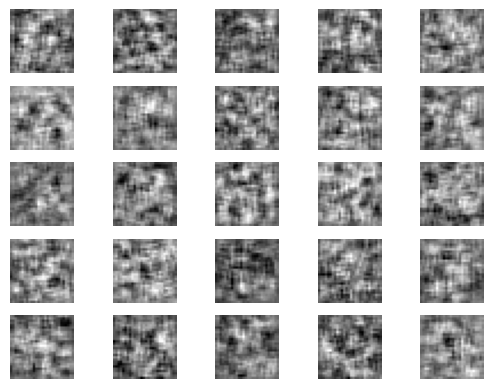

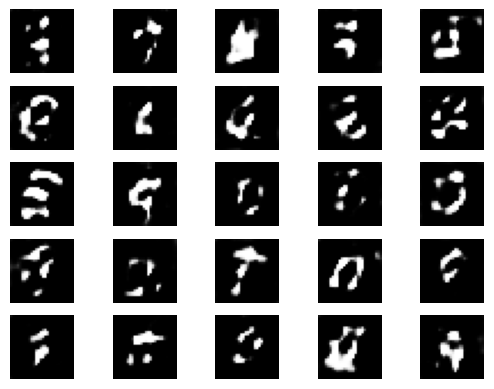

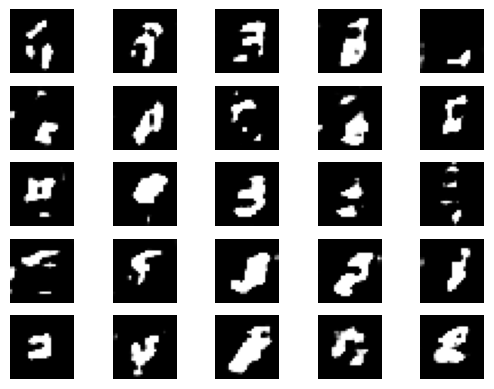

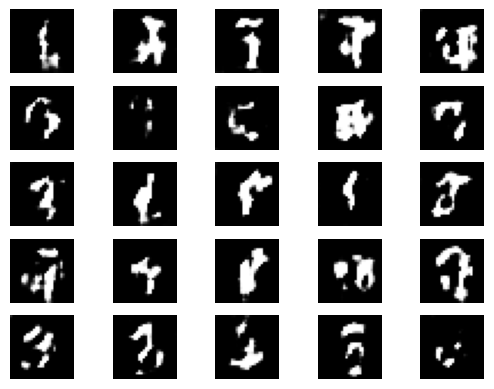

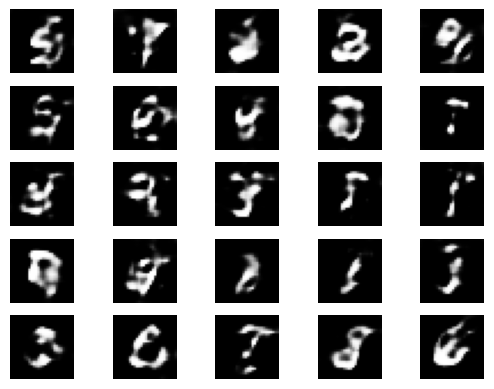

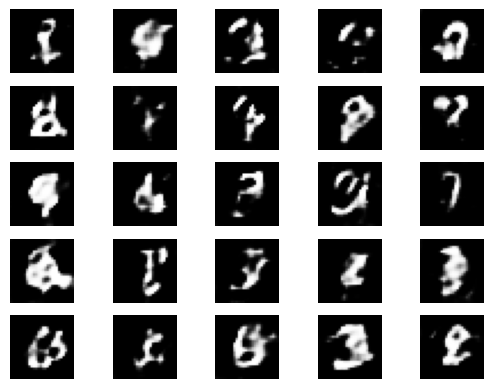

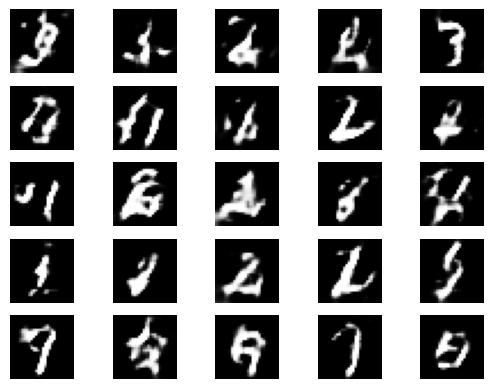

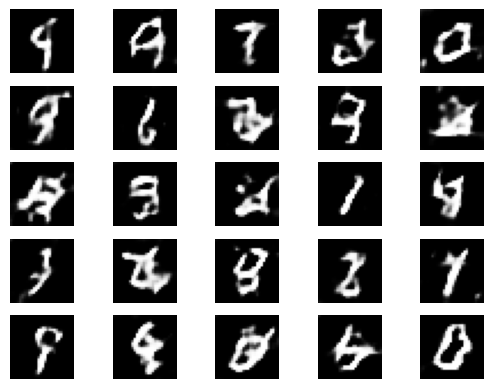

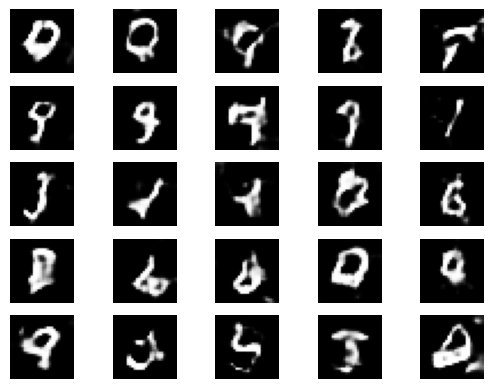

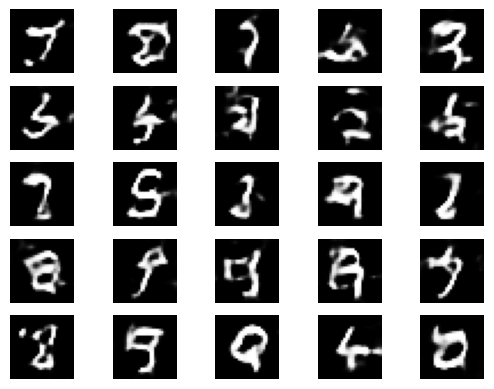

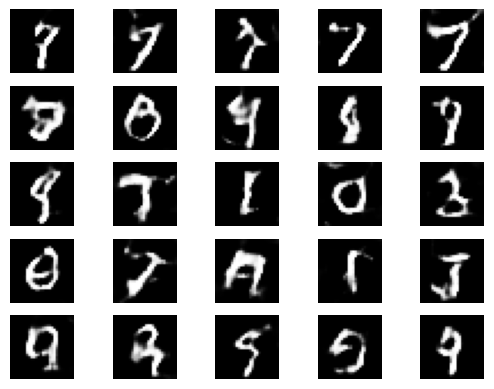

In [6]:
gan_train(2001, 32, 200)
#gan_train(epoch, batch_size, saving_interval)